# Plots for npe-f

In [17]:

# magic command to reload modules
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import sys
import yaml
from sbi import analysis
import os
from scipy.stats import gaussian_kde
from tqdm import tqdm
from scipy.spatial import distance

NSC_DIR = Path(os.getcwd()).resolve().parent.parent.as_posix()  # NSC dir
sys.path.append(f"{NSC_DIR}/codes/src")
from utils.setup import adapt_path
from utils.event import get_train_valid_lr
from utils.plots import load_img, pairplot, plot_posterior_mapped_samples, marginal_plot
from utils.inference import (
    get_posterior,
    load_stored_config,
    sampling_from_posterior,
    # ci_perf_on_dset,
    # ci_perf_on_dset_par,
    perfs_on_dset,
)
from utils.train import WarmupScheduler, plot_posterior_with_label, load_net, get_limits
from simulator.model_sim_pR import DM_sim_for_seqCs_parallel_with_smaller_output
from utils.range import x2seqC, seqC2x, convert_samples_range, convert_array_range
from evaluate.distance_p4 import *
from features.features import feature_extraction

import matplotlib as mpl
import matplotlib.pyplot as plt

# reset matplotlib
# mpl.rcParams.update(mpl.rcParamsDefault)
# # remove top and right axis from plots
# mpl.rcParams["axes.spines.right"] = False
# mpl.rcParams["axes.spines.top"] = False
# # remove all edges

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams["axes.edgecolor"] = "k"
mpl.rcParams["axes.linewidth"] = 2

font = {"weight": "bold"}
mpl.rc("font", **font)

# grid alpha to 0.2
mpl.rcParams["grid.alpha"] = 0.2

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
from features.features import *

fig_dir = Path(f"{NSC_DIR}/codes/notebook/figures/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Features

In [18]:
DATA_PATH = adapt_path("~/tmp/NSC/data/dataset/dataset-L0-Eset0-100sets-T500.h5")
idx_set = 0
idx_theta = 10

# =================================================== load h5 dataset file
f = h5py.File(DATA_PATH, "r")
"""
f has keys ['set_0', 'set_1', 'set_10', 'set_11']
in one set, there are 3 keys: ['seqC', 'theta', 'probR']
seqC:  [D, M, S, 15]            - [7, 3, 700, 15]
theta: [T, 4]                   - [5000, 4]
probR: [D, M, S, T, 1]          - [7, 3, 700, 5000, 1]
"""
seqC = torch.from_numpy(f[f"set_{idx_set}"]["seqC"][:]).type(torch.float32)
theta = torch.from_numpy(f[f"set_{idx_set}"]["theta"][idx_theta, :]).type(torch.float32)
probR = torch.from_numpy(f[f"set_{idx_set}"]["probR"][:, :, :, idx_theta, :]).type(torch.float32)
f.close()

D, M, S = seqC.shape[0], seqC.shape[1], seqC.shape[2]
DMS = D * M * S

In [18]:
sID = 2
trials = sio.loadmat(adapt_path("~/tmp/NSC/data/trials.mat"))
trials_data = trials["data"]
trials_info = trials["info"]
subjectID = torch.from_numpy(trials_data[0, -1])
idx_subj = (subjectID == sID).squeeze(-1)
chR = torch.from_numpy(trials_data[0, 42][idx_subj]).type(torch.float32)
seqC = torch.from_numpy(trials_data[0, 0][idx_subj]).type(torch.float32)
print(f"==>> seqC.shape: {seqC.shape}")
print(f"==>> chR.shape: {chR.shape}")

FG = Feature_Generator()
FG.compute_kernels(seqC, chR, D, M, S)

==>> seqC.shape: torch.Size([14700, 15])
==>> chR.shape: torch.Size([14700, 1])


### kernels

/home/wehe/data/NSC/codes/src/features/features.py:505: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


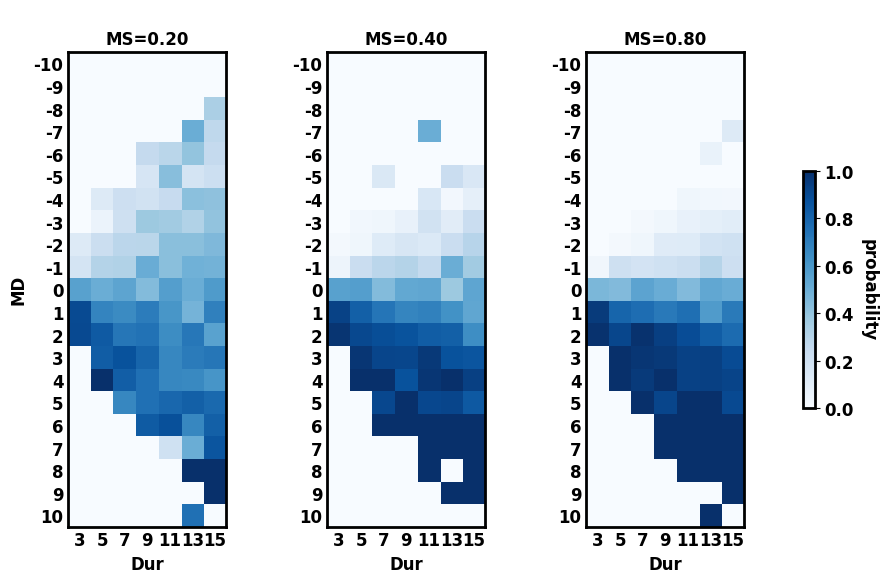

In [7]:
save_fig = fig_dir / 'npe-f' / 'npe-f-F1-kernel.png'
FG.plot_kernels(kernel=1, no_dist=True, save_fig=save_fig)

/home/wehe/data/NSC/codes/src/features/features.py:561: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


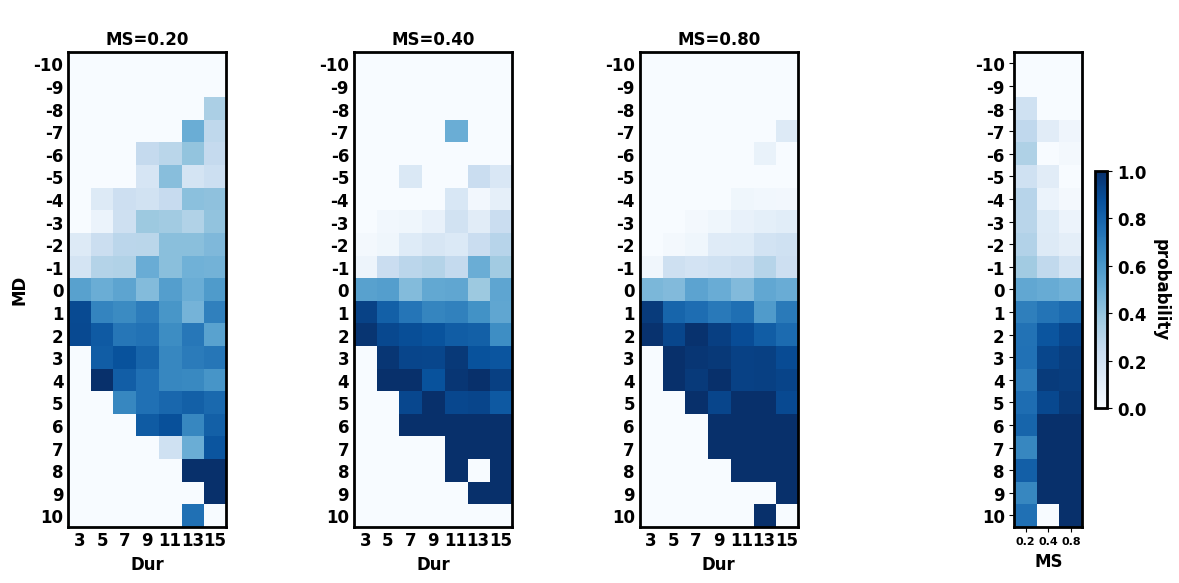

In [8]:
save_fig = fig_dir / 'npe-f' / 'npe-f-F3-kernel.png'
FG.plot_kernels(kernel=3, no_dist=True, save_fig=save_fig)

/home/wehe/data/NSC/codes/src/features/features.py:617: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


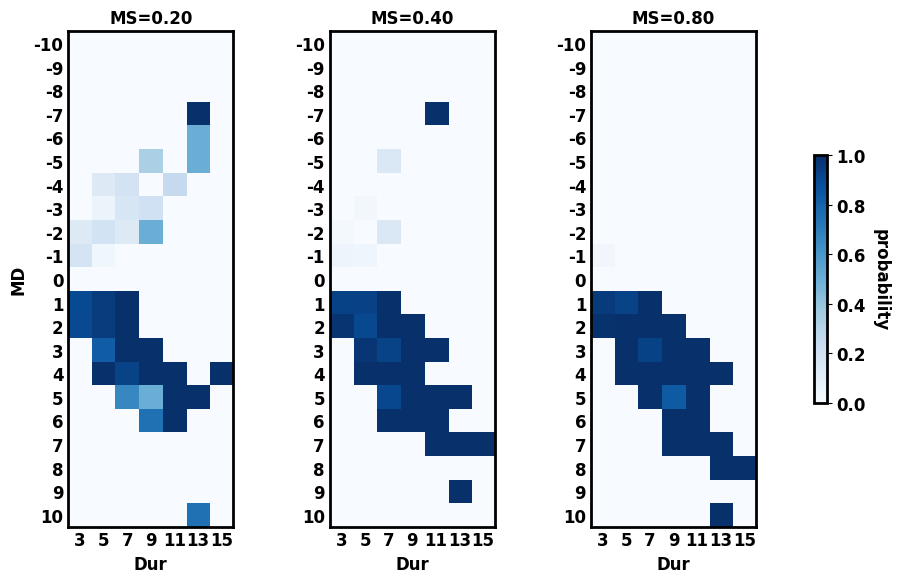

In [9]:
save_fig = fig_dir / 'npe-f' / 'npe-f-F4-kernel.png'
FG.plot_kernels(kernel=4, no_dist=True, save_fig=save_fig)

/home/wehe/data/NSC/codes/src/features/features.py:674: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


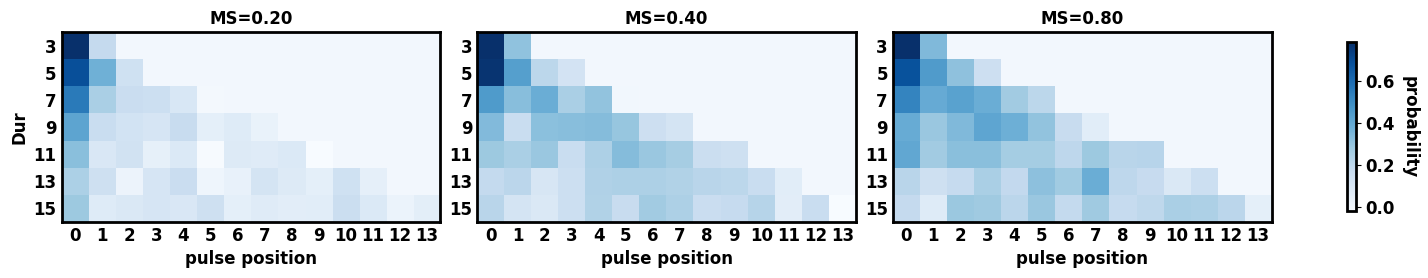

In [10]:
save_fig = fig_dir / 'npe-f' / 'npe-f-F5-kernel.png'
FG.plot_kernels(kernel=5, no_dist=True, save_fig=save_fig)

## Features

In [19]:
feature_1s, feature_2s, feature_3s, feature_4s, feature_5s = FG.get_features()
feature_5s_normed = convert_array_range(feature_5s, [-1, 1], [0, 1])
features = [feature_1s, feature_2s, feature_3s, feature_4s, feature_5s_normed]
# feature = FG.compute_kernels(seqC, chR, D, M, S).get_provided_feature(feature_list=[1,2,3,4,5])
feature_lens = [x.shape[1] for x in features]

feature = []
for i in range(M):
    for j in range(len(features)):
        feature.append(features[j][i])

feature = torch.cat(feature)
feature_lens

[69, 69, 15, 12, 56]

In [20]:
sID = 5
trials = sio.loadmat(adapt_path("~/tmp/NSC/data/trials.mat"))
trials_data = trials["data"]
trials_info = trials["info"]
subjectID = torch.from_numpy(trials_data[0, -1])
idx_subj = (subjectID == sID).squeeze(-1)
chR = torch.from_numpy(trials_data[0, 42][idx_subj]).type(torch.float32)
seqC = torch.from_numpy(trials_data[0, 0][idx_subj]).type(torch.float32)
print(f"==>> seqC.shape: {seqC.shape}")
print(f"==>> chR.shape: {chR.shape}")

FG = Feature_Generator()
FG.compute_kernels(seqC, chR, D, M, S)

feature_1s, feature_2s, feature_3s, feature_4s, feature_5s = FG.get_features()
feature_5s_normed = convert_array_range(feature_5s, [-1, 1], [0, 1])
features_ = [feature_1s, feature_2s, feature_3s, feature_4s, feature_5s_normed]

feature_ = []
for i in range(M):
    for j in range(len(features_)):
        feature_.append(features_[j][i])
feature_ = torch.cat(feature_)

==>> seqC.shape: torch.Size([14700, 15])
==>> chR.shape: torch.Size([14700, 1])


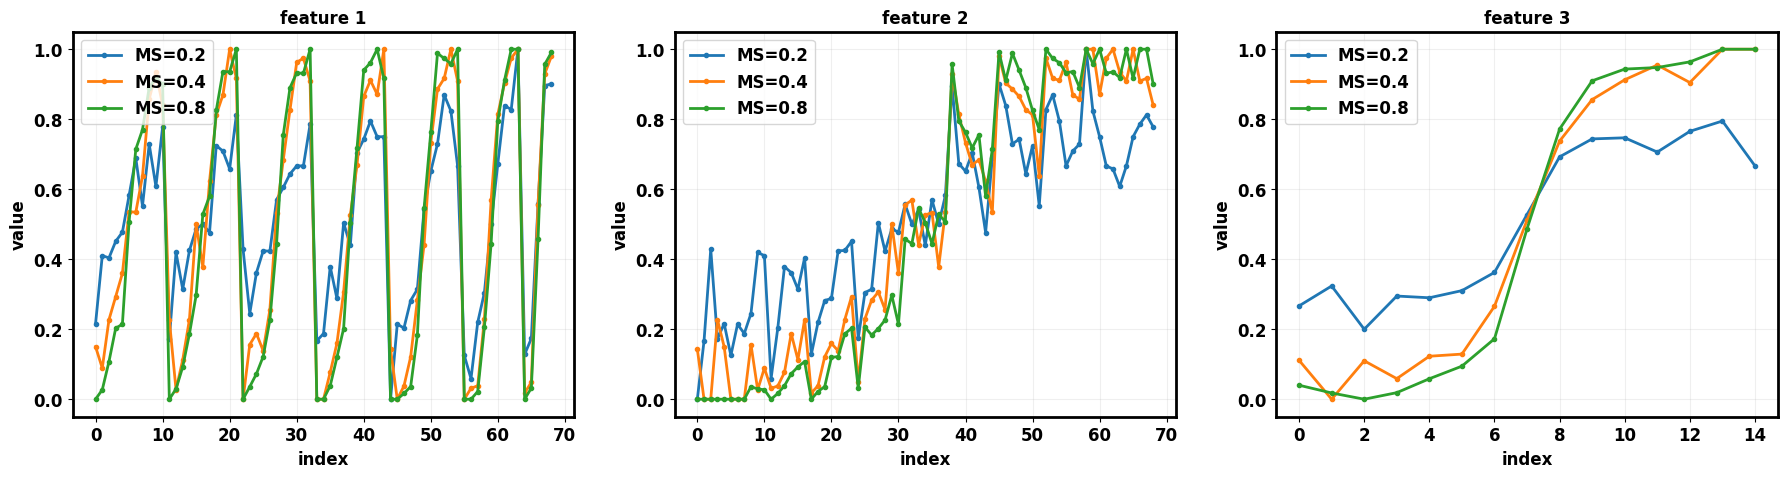

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))

ax = axes[0]
for i in range(M):
    ax.plot(feature_1s[i], ".-", label=f"MS={FG.MS_list[i]:.1f}", linewidth=2, color=colors[i])
ax.set_title("feature 1")
ax.set_xlabel("index")
ax.set_ylabel("value")

ax = axes[1]
for i in range(M):
    ax.plot(feature_2s[i], ".-", label=f"MS={FG.MS_list[i]:.1f}", linewidth=2, color=colors[i])
ax.set_title("feature 2")
ax.set_xlabel("index")
ax.set_ylabel("value")


ax = axes[2]
for i in range(M):
    ax.plot(feature_3s[i], ".-", label=f"MS={FG.MS_list[i]:.1f}", linewidth=2, color=colors[i])
ax.set_title("feature 3")
ax.set_xlabel("index")
ax.set_ylabel("value")
ax.grid(alpha=0.2)
ax.legend()

for ax in axes:
    ax.grid(alpha=0.2)
    ax.legend()
    


    
save_fig = fig_dir / 'npe-f'/ 'npe-f-F123.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

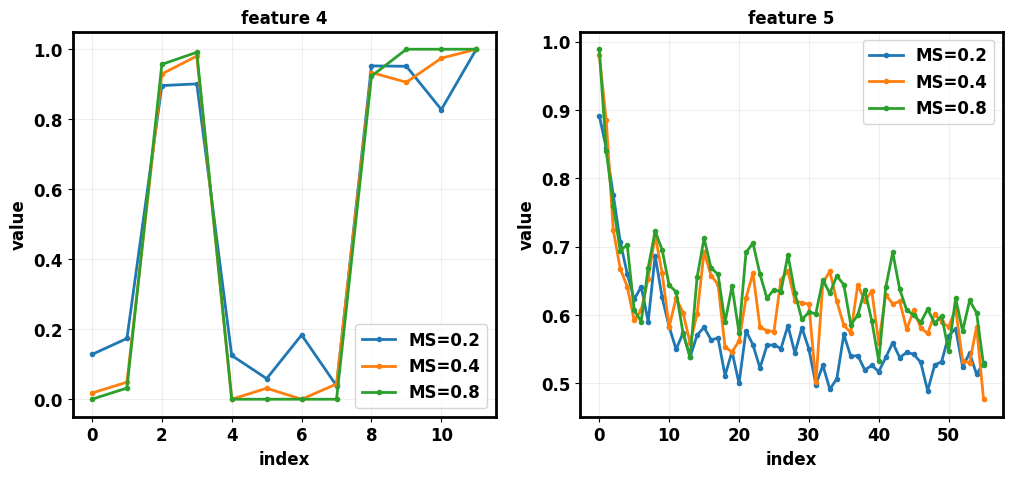

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax = axes[0]
for i in range(M):
    ax.plot(feature_4s[i], ".-", label=f"MS={FG.MS_list[i]:.1f}", linewidth=2, color=colors[i])
ax.set_title("feature 4")
ax.set_xlabel("index")
ax.set_ylabel("value")
ax.grid(alpha=0.2)
ax.legend()

ax = axes[1]
for i in range(M):
    ax.plot(feature_5s_normed[i], ".-", label=f"MS={FG.MS_list[i]:.1f}", linewidth=2, color=colors[i])
ax.set_title("feature 5")
ax.set_xlabel("index")
ax.set_ylabel("value")
ax.grid(alpha=0.2)
ax.legend()

save_fig = fig_dir / 'npe-f'/ 'npe-f-F45.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

In [14]:
pos=0
vline_poss = [0]
for i in range(M):
    for l in feature_lens:
        pos += l
        vline_poss.append(pos)
vM_poss = [0]
for i in range(M):
    vM_poss.append(sum(feature_lens)*(i+1))
# vline_poss = [acc+=l for l in feature_lens for i in range(M)]

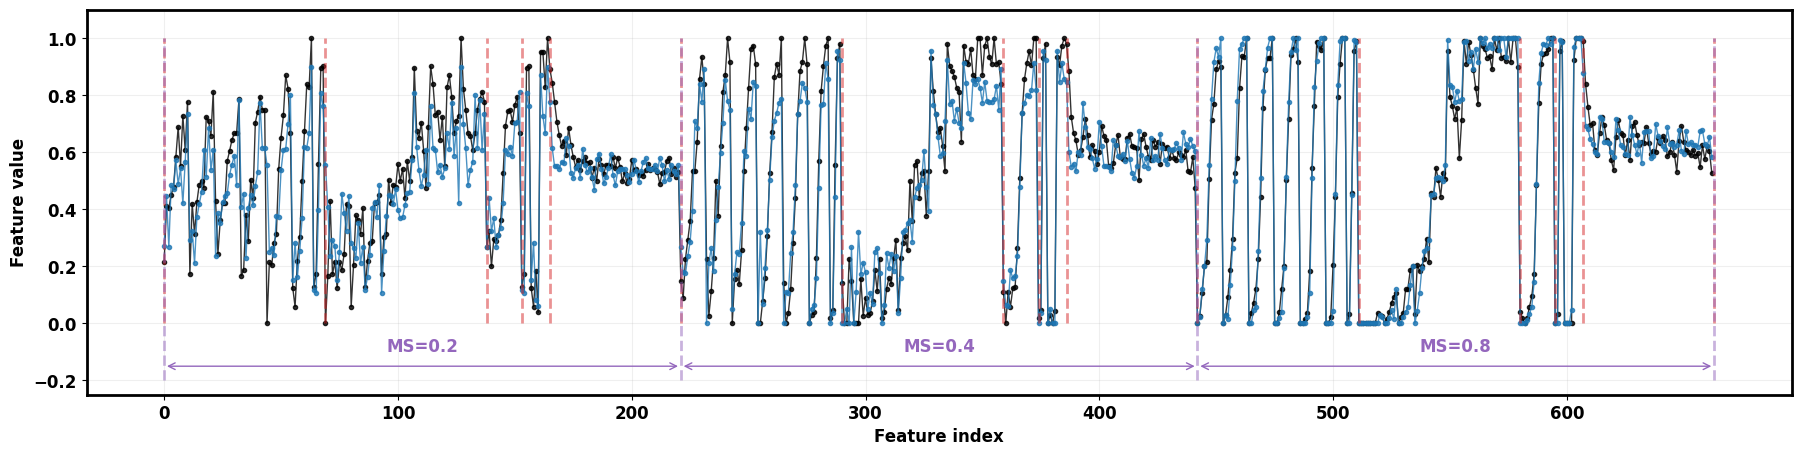

In [33]:
def plot_features(features, features_2, ax, vline_poss, vM_poss, color='k', label=""):
    ax.plot(features, ".-", color=color, linewidth=1, alpha=0.8, label="subject 2")
    ax.plot(features_2, ".-", color='tab:blue', linewidth=1, alpha=0.8, label="subject 5")
    ax.vlines(vline_poss, 0, 1, color=colors[3], linewidth=2, linestyle='--', alpha=0.5)
    ax.vlines(vM_poss, -0.2, 1, color=colors[4], linewidth=2, linestyle='--', alpha=0.5)

    # ax.xlim(-10, vM_poss[-1]+10)
    # Adding arrows and text
    y_pos = -0.15 # Adjust this value based on where you want the text to appear
    for i in range(len(vM_poss) - 1):
        mid_point = (vM_poss[i] + vM_poss[i + 1]) / 2
        ax.text(mid_point, y_pos + 0.1, f'MS={0.2 * 2 ** i}', ha='center', va='top', color=colors[4]) # Text just below arrow
        ax.annotate("",
                    xy=(vM_poss[i], y_pos), xycoords='data',
                    xytext=(vM_poss[i + 1], y_pos), textcoords='data',
                    arrowprops=dict(arrowstyle="<->", color=colors[4],
                                    connectionstyle="arc3"),
                    )

    ax.grid(alpha=0.2)
    ax.set_ylim(-0.25, 1.1)
    ax.set_xlabel("Feature index")
    ax.set_ylabel("Feature value")
    
    # y_pos = 1.15
    # f_counter = 0
    # for i in range(len(vline_poss) - 1):
    #     f_counter += 1
    #     if f_counter == 6:
    #         f_counter = 1
    #     mid_point = (vline_poss[i] + vline_poss[i + 1]) / 2
    #     plt.text(mid_point, y_pos + 0.1, f'F{f_counter}', ha='center', va='top') # Text just below arrow
    #     plt.annotate("",
    #                  xy=(vline_poss[i], y_pos), xycoords='data',
    #                  xytext=(vline_poss[i + 1], y_pos), textcoords='data',
    #                  arrowprops=dict(arrowstyle="<->", color='tab:blue',
    #                                  connectionstyle="arc3"),
    #                  )

fig, ax = plt.subplots(1, 1, figsize=(22, 5))
plot_features(feature, feature_,  ax, vline_poss, vM_poss)

save_fig = fig_dir / 'npe-f'/ 'npe-f-F1to5.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## Prepared Dataset 

In [167]:
feature_dir = Path(NSC_DIR) / "data/dataset/feature-L0-Eset0-100sets-T500-C100.h5"
# load the file
f = h5py.File(feature_dir, "r")
# get the keys
sets = list(f.keys())
T, C, M, _ = f[sets[0]][f"feature_{1}"].shape

features_collection = []
set_idxs = [0,  0, 1, 1, 10]
T_idxs   = [0,  0, 0, 1, 6]
C_idxs   = [0, 10, 0, 0, 0]

set_idxs = [0,  0, 0, ]
T_idxs   = [0,  0, 1, ]
C_idxs   = [0, 10, 0, ]

for i in range(len(set_idxs)):
    set_idx, T_idx, C_idx = set_idxs[i], T_idxs[i], C_idxs[i]
    data_collection = []
    for F_idx in range(1, 6):
        data = f[sets[set_idx]][f"feature_{F_idx}"][T_idx, C_idx]
        if F_idx ==5:
            data = convert_array_range(data, original_range=[-1, 1], dest_range=[0, 1])
        data_collection.append(data)
    data_collection = np.concatenate(data_collection, axis=-1).reshape(-1)
    features_collection.append(data_collection)

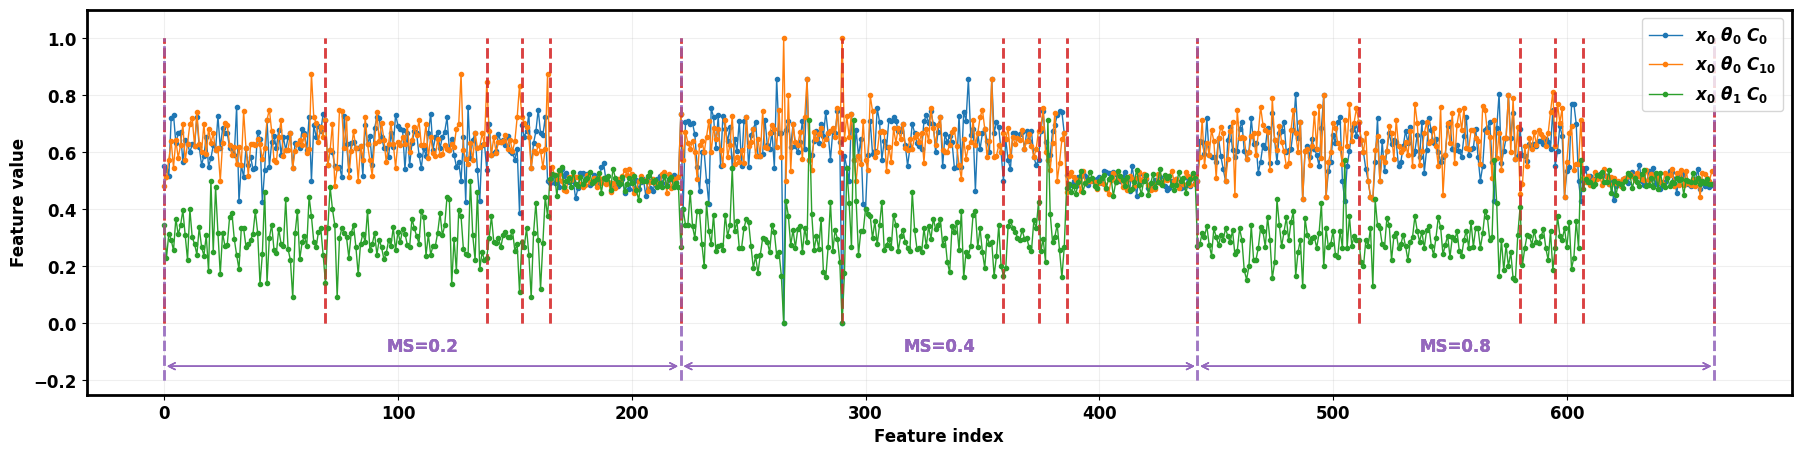

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(22, 5))
for i in range(len(set_idxs)):
    theta_ = rf"$\theta_{T_idxs[i]}$"
    ch_ = r"$C_{" + f"{C_idxs[i]}" + r"}$"
    label = f"$x_{set_idxs[i]}$ {theta_} {ch_}"
    plot_features(features_collection[i], ax, vline_poss, vM_poss, color=colors[i], label=label)
ax.legend()

save_fig = fig_dir / 'npe-f'/ 'npe-f-F1to5-simulator.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

# load training data

In [5]:
# %% ==================================================
pipeline_version = "p4a"
train_id = "train_L0_p4a"
exp_id = "p4a-F1345-cnn-maf3"
# exp_id = "p4a-F1345-cnn-maf3-tmp"
log_exp_id = "npe-f-F1345-maf3"

log_dir = Path(NSC_DIR) / "codes/src/train/logs" / train_id / exp_id

# %% ========== load the config.yaml file
config_file = log_dir / "config.yaml"
config = adapt_path(config_file)

with open(config, "r") as f:
    config = yaml.safe_load(f)

prior_min = config["prior"]["prior_min"]
prior_max = config["prior"]["prior_max"]
# prior_labels = config["prior"]["prior_labels"]
prior_labels = ["$b$", "$\sigma^2_a$", "$\sigma^2_s$", "$\lambda$"]
num_params = len(prior_labels)

## training curve

In [6]:
# %% ========== load the latest event file

# (
#     wall_time,
#     step_nums,
#     learning_rates,
#     log_probs_train,
#     log_probs_valid,
# ) = get_train_valid_lr(log_dir)

# all_probs = np.concatenate([log_probs_train, log_probs_valid])
# upper = np.max(all_probs)
# lower = np.percentile(all_probs, 10)

# # %% ========== plot training curves
# fig, ax = plt.subplots(figsize=(8, 2.5))
# ax.plot(step_nums, log_probs_valid, label="validation", alpha=0.6, ms=0.2, color=colors[1])
# ax.plot(step_nums, log_probs_train, label="train", alpha=0.6, ms=0.2, color=colors[0])
# ax.set_ylim(lower, upper)
# ax.set_xlabel("epoch")
# ax.set_ylabel("$\log(p)+\log|det|$")
# # ax.grid(alpha=0.2)
# ax.legend()

# ax1 = ax.twiny()
# ax1.plot(
#     (np.array(wall_time) - wall_time[0]) / 60 / 60,
#     max(log_probs_valid) * np.ones_like(log_probs_valid),
#     "-",
#     alpha=0,
# )
# ax1.set_xlabel("time (hours)")

# save_fig = fig_dir / 'npe-f' / f'{log_exp_id}-training-curve.png'
# fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## Training Progress

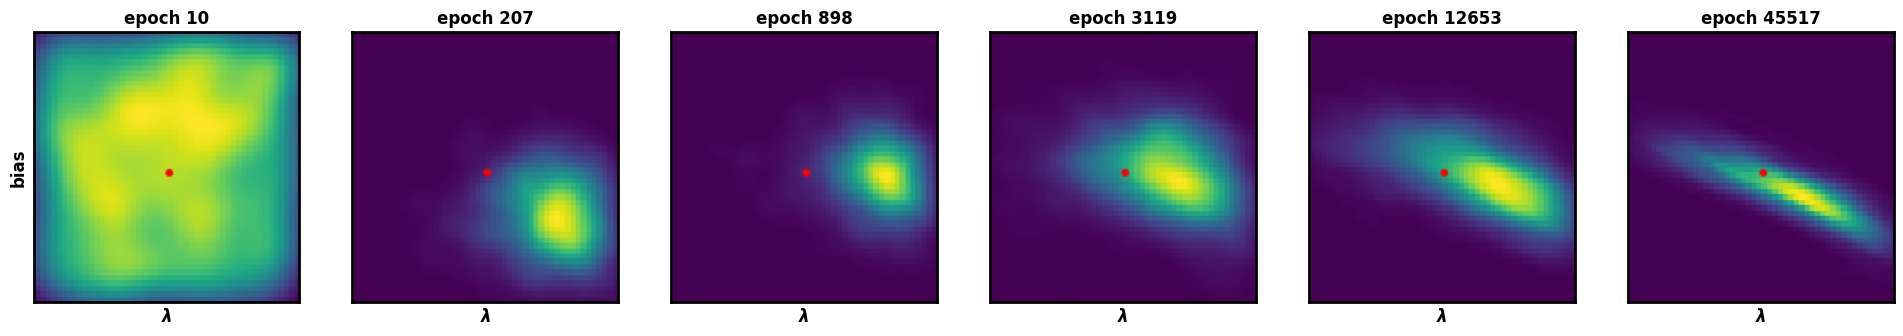

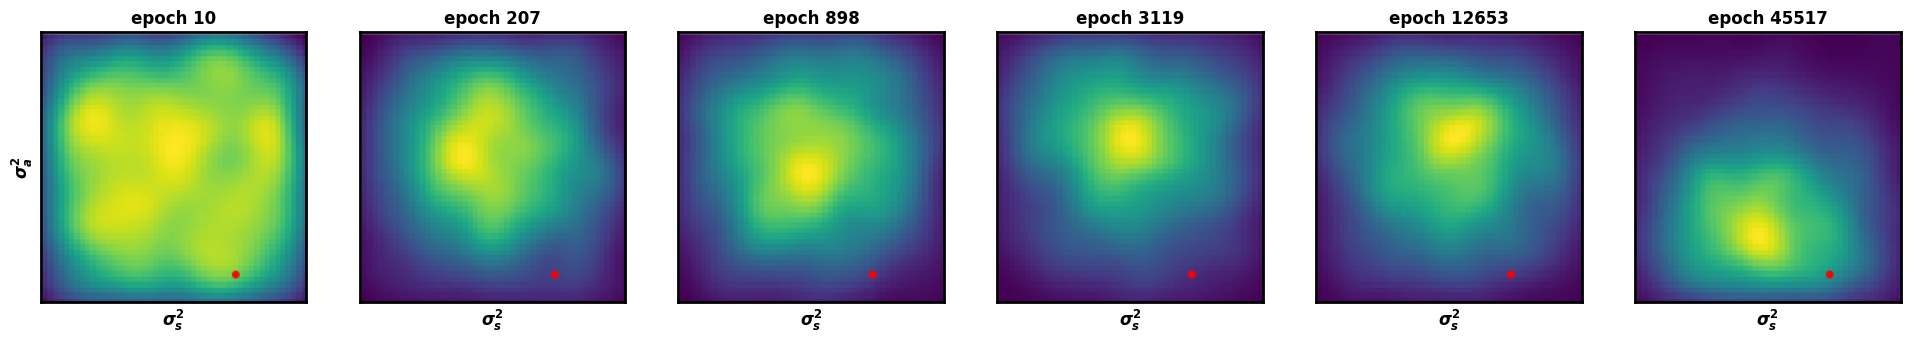

In [7]:
# %% ========== plot posterior training process
num_epoch = 6
best_epoch = step_nums[np.argmax(log_probs_valid)]

# get recorded posterior plot names
img_folder = Path(f"{log_dir}/posterior/figures")
posterior_plots = img_folder.glob("posterior_seen_0*.png")
posterior_idx = [eval(str(plot).split("epoch_")[-1].split(".png")[0]) for plot in posterior_plots]
posterior_idx = np.array(posterior_idx)[np.argsort(posterior_idx)]

chosen_idx = np.linspace(10, len(posterior_idx) - 1, num_epoch, dtype=int)

BL_coor = [731, 731 + 170, 99, 99 + 173]  # x_start, x_end, y_start, y_end
BL_labels = ["$\lambda$", "bias"]
AS_coor = [528, 528 + 170, 304, 304 + 173]  # x_start, x_end, y_start, y_end
AS_labels = ["$\sigma^2_s$", "$\sigma^2_a$"]

coor = BL_coor
labels = BL_labels

# coor = AS_coor
# labels = AS_labels
fig, axes = plt.subplots(1, num_epoch, figsize=(num_epoch * 4, 4))
for i, epoch_idx in enumerate(chosen_idx):
    ax = axes[i]
    img_path = img_folder / f"posterior_seen_0_epoch_{posterior_idx[epoch_idx]}.png"
    if img_path.exists():
        load_img(
            img_path=img_path,
            ax=ax,
            title=f"epoch {posterior_idx[epoch_idx]}",
            crop=True,
            x_start=coor[0],
            x_end=coor[1],
            y_start=coor[2],
            y_end=coor[3],
        )
    ax.set_xlabel(labels[0])
    if i == 0:
        ax.set_ylabel(labels[1])

save_fig = fig_dir / 'npe-f' / f'{log_exp_id}-train-progress-BL0.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

coor = AS_coor
labels = AS_labels
fig, axes = plt.subplots(1, num_epoch, figsize=(num_epoch * 4, 4))
for i, epoch_idx in enumerate(chosen_idx):
    ax = axes[i]
    img_path = img_folder / f"posterior_seen_0_epoch_{posterior_idx[epoch_idx]}.png"
    if img_path.exists():
        load_img(
            img_path=img_path,
            ax=ax,
            title=f"epoch {posterior_idx[epoch_idx]}",
            crop=True,
            x_start=coor[0],
            x_end=coor[1],
            y_start=coor[2],
            y_end=coor[3],
        )
    ax.set_xlabel(labels[0])
    if i == 0:
        ax.set_ylabel(labels[1])
        
save_fig = fig_dir / 'npe-f' / f'{log_exp_id}-train-progress-sigmas.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## Load posterior samples 

In [19]:
# %% ==========  get posterior samples
config, model_path = load_stored_config(exp_dir=log_dir)

if "p4" in pipeline_version:
    from train.train_L0_p4a import Solver
if "p5" in pipeline_version:
    from train.train_L0_p5a import Solver

solver, posterior, train_loader, valid_loader, train_dataset, valid_dataset = get_posterior(
    model_path=model_path,
    config=config,
    device="cuda",
    Solver=Solver,
    low_batch=20,
    return_dataset=True,
)

==>> config_path: /home/wehe/data/NSC/codes/src/train/logs/train_L0_p4a/p4a-F1345-cnn-maf3/config.yaml
using device: cuda

--- CUDA info ---
NVIDIA RTX A6000
Memory Usage:
Allocated: 0.1 GB
Cached:    0.2 GB
--- CUDA info ---

prior min before norm: [-2.5, 0, 0, -11]
prior max before norm: [2.5, 77, 18, 10]
prior min: [0. 0. 0. 0.]
prior max: [1. 1. 1. 1.]

=== embedding net === 
cnn

=== train, val dataset and dataloader ===
train_set_names=['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24']
valid_set_names=['set_25', 'set_26']
[training] sets len_feature_each_type=[69, 15, 12, 56]
loading 18sets T100.00% C25...


100%|██████████| 18/18 [00:00<00:00, 43.60it/s]


dataset info: ==> self.total_samples=225000 => self.x.shape=torch.Size([18, 500, 25, 456, 1]) self.theta.shape=torch.Size([18, 500, 4])

[validation] sets len_feature_each_type=[69, 15, 12, 56]
loading 2sets T100.00% C25...


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 46.97it/s]

dataset info: ==> self.total_samples=25000 => self.x.shape=torch.Size([2, 500, 25, 456, 1]) self.theta.shape=torch.Size([2, 500, 4])
loader_kwargs={'batch_size': 20, 'drop_last': False, 'shuffle': True, 'pin_memory': False, 'num_workers': 4, 'worker_init_fn': <function seed_worker at 0x7fd90a6ee170>, 'prefetch_factor': 2}

collect posterior sets... 

takes 0.75 seconds = 0.01 minutes

finished build network
Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=128, bias=True)
          (context_layer): Linear(in_features=256, out_features=128, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=128, out_features=8, bias=True)
        )
      )
      (1): RandomPermutation()
      (2): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=128, bias=True)
          (context_layer): Linear(in_features=256, out_features=128, bias=True)

In [20]:
normed_limits = solver._get_limits()
designed_limits = get_limits(config.prior.prior_min, config.prior.prior_max)

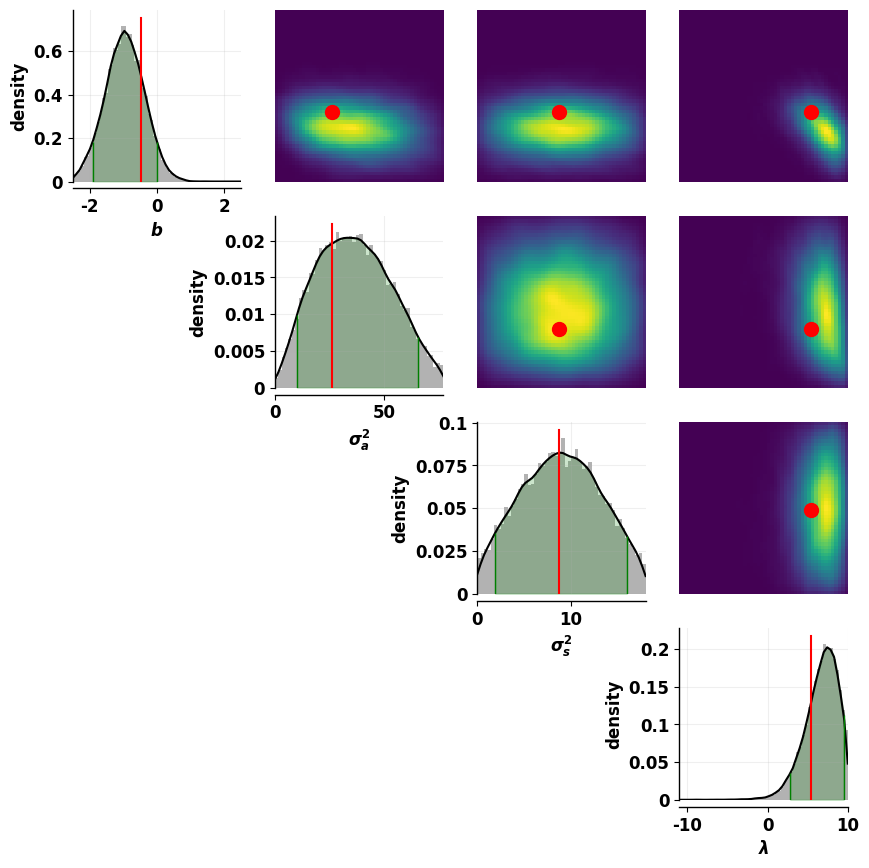

In [21]:
# # %% load one sample - training sample
# # seen_data = solver.inference.seen_data_for_posterior
# f_o, true_theta = train_dataset[1]

# fig, ax, samples = plot_posterior_mapped_samples(
#     posterior,
#     f_o,
#     true_theta=true_theta,
#     num_samples=20_000,
#     sampling_device="cuda",
#     show_progress_bars=False,
#     original_limits=normed_limits,
#     mapped_limits=designed_limits,
# )

# save_fig = fig_dir / 'npe-f' / f'{log_exp_id}-train-posterior.png'
# fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

f_o, true_theta = valid_dataset[10000]
fig, ax, samples = plot_posterior_mapped_samples(
    posterior,
    f_o,
    true_theta=true_theta,
    num_samples=20_000,
    sampling_device="cuda",
    show_progress_bars=False,
    original_limits=normed_limits,
    mapped_limits=designed_limits,
)

save_fig = fig_dir / 'npe-f' / f'{log_exp_id}-valid-posterior.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

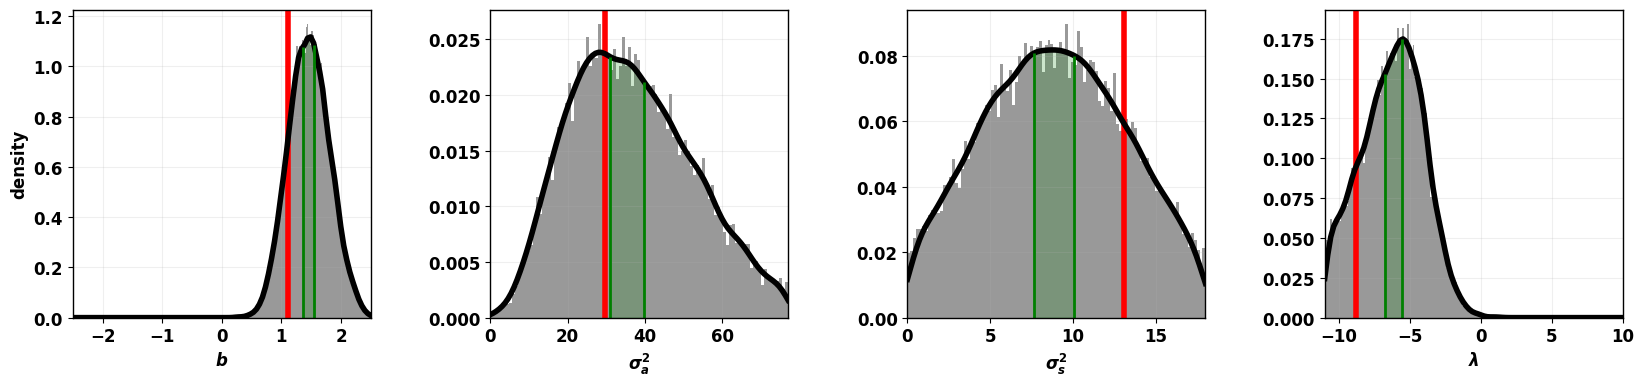

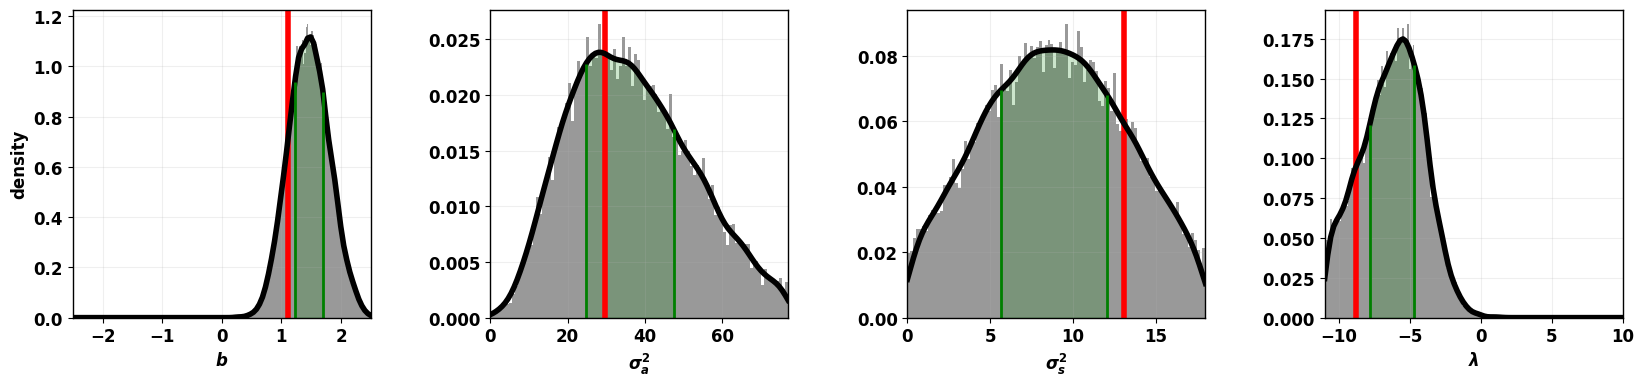

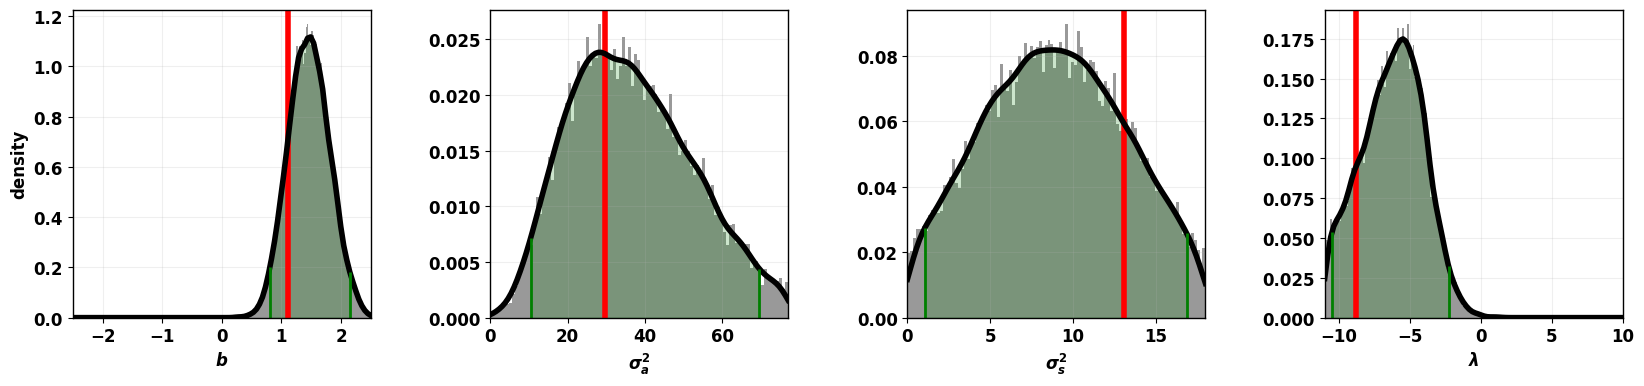

In [9]:
credible_intervals = [20, 50, 95]
for credible_interval in credible_intervals:
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    fig.subplots_adjust(wspace=0.4)
    true_theta_dr = convert_samples_range(true_theta, normed_limits, designed_limits)
    axes = marginal_plot(
        samples,
        true_theta_dr,
        origin_limits=designed_limits,
        dest_limits=designed_limits,
        credible_interval=credible_interval,
        axes=axes,
    )
    for i in range(len(axes)):
        axes[i].set_xlabel(prior_labels[i])

    save_fig = fig_dir / 'npe-f' / f'{log_exp_id}-margin-ci{credible_interval}.png'
    fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## [Qualitative] change one of the parameter and see how the prediction changes

prepare the changing theta values

In [115]:
# prepare varying theta values
print(f"{designed_limits=}")
ref_theta_values = [1, 10, 10, 1]

step = 7
theta_values = np.ones((4 * step, 4))
for i in range(len(ref_theta_values)):
    theta_values[:, i] = ref_theta_values[i]

for i, limits in enumerate(designed_limits):
    values = np.linspace(limits[0], limits[1], step)
    theta_values[i * step : (i + 1) * step, i] = values

print(f"==>> theta_values: {theta_values}")    

designed_limits=[[-2.5, 2.5], [0, 77], [0, 18], [-11, 10]]
==>> theta_values: [[ -2.5         10.          10.           1.        ]
 [ -1.66666667  10.          10.           1.        ]
 [ -0.83333333  10.          10.           1.        ]
 [  0.          10.          10.           1.        ]
 [  0.83333333  10.          10.           1.        ]
 [  1.66666667  10.          10.           1.        ]
 [  2.5         10.          10.           1.        ]
 [  1.           0.          10.           1.        ]
 [  1.          12.83333333  10.           1.        ]
 [  1.          25.66666667  10.           1.        ]
 [  1.          38.5         10.           1.        ]
 [  1.          51.33333333  10.           1.        ]
 [  1.          64.16666667  10.           1.        ]
 [  1.          77.          10.           1.        ]
 [  1.          10.           0.           1.        ]
 [  1.          10.           3.           1.        ]
 [  1.          10.           6.          

prepare unseen valid data from 'set_25'

In [116]:
# prepare the seqC_o from unseen dataset ['set_25']
f = h5py.File(DATA_PATH, "r")
f.keys()
seqC = f['set_25']['seqC'][:]
f.close()
print(f"==>> seqC.shape: {seqC.shape}")
print(f'{seqC[0,0,:5,:]=}')
D, M, S = seqC.shape[0], seqC.shape[1], seqC.shape[2]
DMS = D * M * S

==>> seqC.shape: (7, 3, 700, 15)
seqC[0,0,:5,:]=array([[ 0. ,  0. , -0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ 0. ,  0. , -0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ 0. , -0.2,  0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ 0. , -0.2, -0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ 0. ,  0.2, -0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan]])


run the simulator -> get probR -> sample into chR: </br>

In [121]:
# run the simulator
params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
    seqCs=seqC,
    prior=theta_values,
    num_workers=16,
    privided_prior=True,
)


--- simulating pR with... ---
prior sample size: 1
model_name: B-G-L0S-O-N-
total number of simulations 411600 with 16 workers ...



/tmp/ipykernel_527136/2629399163.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.5s
[Parallel(n_jobs=16)]: Done 865 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done 41472 tasks      | elapsed:    5.4s
[Parallel(n_jobs=16)]: Done 131072 tasks      | elapsed:    9.1s
[Parallel(n_jobs=16)]: Done 246272 tasks      | elapsed:   14.0s
[Parallel(n_jobs=16)]: Done 387072 tasks      | elapsed:   20.3s


time elapsed for simulation: 0.36 minutes
stacking the results
done stacking the results

seqC.shape: (7, 3, 700, 15), params.shape: (28, 4), probR.shape: (7, 3, 700, 28, 1)


[Parallel(n_jobs=16)]: Done 411600 out of 411600 | elapsed:   21.4s finished


In [122]:
# bernoulli sampling using pytorch
chRs = torch.from_numpy(probR).repeat_interleave(10, dim=-1)
chRs = torch.bernoulli(chRs)
print(f"==>> chR.shape: {chRs.shape}")

==>> chR.shape: torch.Size([7, 3, 700, 28, 10])


extract feature from seqC+chR

In [123]:
chosen_features_lens = config.dataset.feature_lengths
n_features = sum(chosen_features_lens)
print(f"==>> n_features: {n_features*M}")

==>> n_features: 456


In [126]:
seqC.shape, seqC

((7, 3, 700, 15),
 array([[[[ 0. ,  0. , -0.2, ...,  nan,  nan,  nan],
          [ 0. ,  0. , -0.2, ...,  nan,  nan,  nan],
          [ 0. , -0.2,  0.2, ...,  nan,  nan,  nan],
          ...,
          [ 0. , -0.2,  0. , ...,  nan,  nan,  nan],
          [ 0. ,  0.2,  0.2, ...,  nan,  nan,  nan],
          [ 0. ,  0. ,  0.2, ...,  nan,  nan,  nan]],
 
         [[ 0. , -0.4, -0.4, ...,  nan,  nan,  nan],
          [ 0. ,  0. , -0.4, ...,  nan,  nan,  nan],
          [ 0. ,  0.4, -0.4, ...,  nan,  nan,  nan],
          ...,
          [ 0. ,  0. ,  0.4, ...,  nan,  nan,  nan],
          [ 0. , -0.4, -0.4, ...,  nan,  nan,  nan],
          [ 0. ,  0.4,  0. , ...,  nan,  nan,  nan]],
 
         [[ 0. , -0.8, -0.8, ...,  nan,  nan,  nan],
          [ 0. ,  0. ,  0.8, ...,  nan,  nan,  nan],
          [ 0. ,  0. , -0.8, ...,  nan,  nan,  nan],
          ...,
          [ 0. , -0.8, -0.8, ...,  nan,  nan,  nan],
          [ 0. ,  0. ,  0.8, ...,  nan,  nan,  nan],
          [ 0. , -0.8, -0.8, .

In [30]:
T_idx = 0
C_idx = 0
nT = theta_values.shape[0]
Fs = torch.zeros((nT, n_features * M))

for T_idx in tqdm(range(nT)):
    chR = chRs[:, :, :, T_idx, C_idx].unsqueeze(-1)
    F = feature_extraction(seqC, chR, config)
    Fs[T_idx] = F

print(f"==>> Fs.shape: {Fs.shape}")

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:18<00:00,  1.55it/s]

==>> Fs.shape: torch.Size([28, 456])


In [128]:
F_test.shape

torch.Size([1, 456, 1])

In [130]:
all_samples = np.zeros((4, step - 2, 20_000, 4))
all_thetas = np.zeros((4, step - 2, 4))

for T in range(nT):
    if T % step == 0 or T % step == step - 1:
        continue

    moving_theta_idx = T // step
    trial_idx = T % step - 1

    theta_test = torch.tensor(theta_values[T, :])
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    
    F_test = Fs[T, :].unsqueeze(0).unsqueeze(-1).cuda()

    samples = sampling_from_posterior(
        "cuda",
        posterior,
        F_test,
        num_samples=20_000,
        show_progress_bars=False,
    )
    all_samples[moving_theta_idx, trial_idx, :, :] = samples
    all_thetas[moving_theta_idx, trial_idx, :] = theta_test

all_samples_dr = convert_samples_range(all_samples, normed_limits, designed_limits)
all_thetas_dr = convert_samples_range(all_thetas, normed_limits, designed_limits)

/home/wehe/data/NSC/codes/src/utils/range.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples = torch.tensor(samples, dtype=torch.float32)


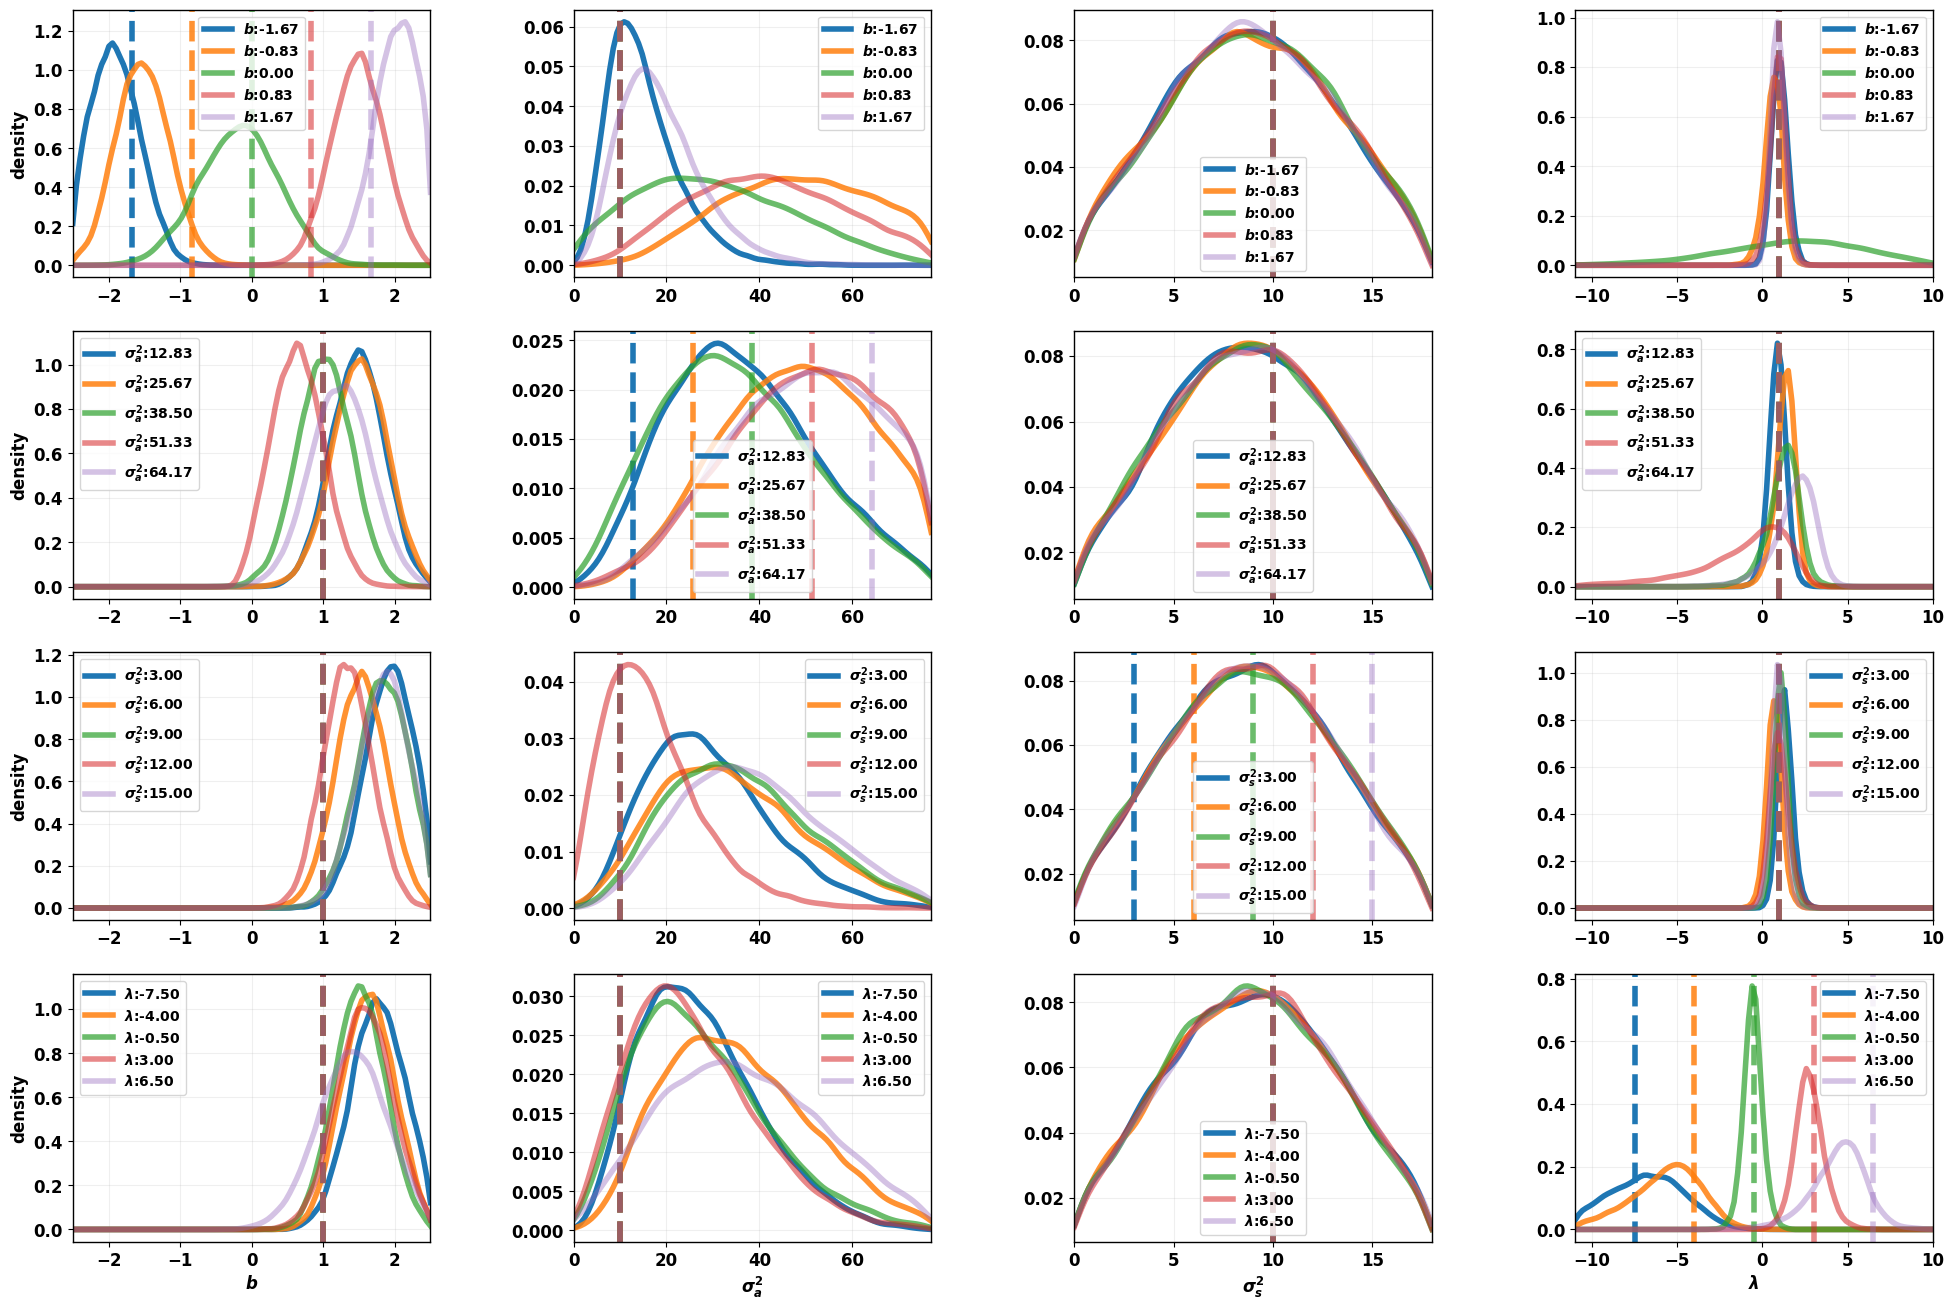

In [32]:
prior_labels = ["$b$", "$\sigma^2_a$", "$\sigma^2_s$", "$\lambda$"]

fig, axes = plt.subplots(
    all_thetas_dr.shape[0],
    all_thetas_dr.shape[-1],
    figsize=(all_thetas_dr.shape[-1] * 6, 4 * all_thetas_dr.shape[0]),
)
fig.subplots_adjust(wspace=0.4)
num_trials = all_thetas_dr.shape[1]

dest_limits = designed_limits

for i in range(all_thetas_dr.shape[0]):
    ax_row = axes[i, :]
    samples_row = all_samples_dr[i]
    moving_theta_idx = i

    for j in range(num_params):
        for k in range(num_trials):
            ax = ax_row[j]
            # density estimation
            density = gaussian_kde(samples_row[k, :, j], bw_method="scott")
            xs = np.linspace(dest_limits[j][0], dest_limits[j][1], 100)
            ys = density(xs)
            # plot kde
            ax.plot(
                xs,
                ys,
                color=colors[k],
                linewidth=4,
                label=f"{prior_labels[i]}:{all_thetas_dr[i, k, i]:.2f}",
                alpha=1 - 0.6 * k / (num_trials - 1),
            )
            ax.set_xlim(dest_limits[j][0], dest_limits[j][1])
            ax.legend(fontsize=10)
            # 
            ax.axvline(
                all_thetas_dr[i, k, j],
                color=colors[k],
                linestyle="--",
                linewidth=4,
                alpha=1 - 0.6 * k / (num_trials - 1),
            )
            ax.grid(alpha=0.2)
        if j == 0:
                ax.set_ylabel("density")
        
        if i == num_params-1:
            ax.set_xlabel(prior_labels[j])

save_fig = fig_dir / 'npe-f' / f'{log_exp_id}-change-of-variables.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## [test acc] check acc

In [46]:
from utils.inference import estimate_theta_from_post_samples
from simulator.seqC_generator import seqC_generator
from simulator.DM_model import DM_model
model_name = 'B-G-L0S-O-N-'

In [34]:
theta_estimate = np.zeros((all_samples_dr.shape[0], all_samples_dr.shape[1], all_samples_dr.shape[-1]))
for i in range(all_samples_dr.shape[0]):
    for j in tqdm(range(all_samples_dr.shape[1])):
        theta_estimate[i, j, :] = estimate_theta_from_post_samples(dest_limits, all_samples_dr[i,j], mode="mode")

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


In [35]:
all_thetas_dr.shape, theta_estimate.shape

(torch.Size([4, 5, 4]), (4, 5, 4))

In [36]:
all_thetas_dr[0:2,0:2], theta_estimate[0:2,0:2]

(tensor([[[-1.6667, 10.0000, 10.0000,  1.0000],
          [-0.8333, 10.0000, 10.0000,  1.0000]],
 
         [[ 1.0000, 12.8333, 10.0000,  1.0000],
          [ 1.0000, 25.6667, 10.0000,  1.0000]]]),
 array([[[-1.95578231, 10.93837535,  9.00360144,  0.99159664],
         [-1.55162065, 45.20168067,  8.20408163,  0.65546218]],
 
        [[ 1.50560224, 31.0280112 ,  8.37695078,  0.89915966],
         [ 1.53161265, 49.33053221,  8.75870348,  1.47058824]]]))

In [107]:
setup_seed(0)
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[9],
    MS_list=[0.4],
    seqC_sample_per_MS=1,
)
print(f"\n==>> seqC: {seqC}")


--- generated seqC info ---
dur_list: [9]
MS_list: [0.4]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)

==>> seqC: [[[[0.  0.  0.4 0.  0.  0.  0.  0.  0.4 nan nan nan nan nan nan]]]]


In [108]:
probR_estimate = []
probR_true = []
for i in range(all_thetas_dr.shape[0]):
    for j in tqdm(range(all_thetas_dr.shape[1])):
        params=theta_estimate[i,j]
        model = DM_model(params=params, model_name=model_name)
        a, probR = model.simulate(seqC)
        probR_estimate.append(probR)
        
        params=all_thetas_dr[i,j]
        model = DM_model(params=params, model_name=model_name)
        a, probR = model.simulate(seqC)
        probR_true.append(probR)
        print(f"==>> true a[-1]: {a[-1]}, params: {params}, probR: {probR}")

100%|██████████| 5/5 [00:00<00:00, 698.52it/s]


==>> true a[-1]: 0.17521343308796897, params: tensor([-1.6667, 10.0000, 10.0000,  1.0000]), probR: 0.6082143658517221
==>> true a[-1]: 0.17521343308796897, params: tensor([-0.8333, 10.0000, 10.0000,  1.0000]), probR: 0.5597747953122932
==>> true a[-1]: 0.17521343308796897, params: tensor([ 0.0000, 10.0000, 10.0000,  1.0000]), probR: 0.5104225712691928
==>> true a[-1]: 0.17521343308796897, params: tensor([ 0.8333, 10.0000, 10.0000,  1.0000]), probR: 0.46091006195225603
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.6667, 10.0000, 10.0000,  1.0000]), probR: 0.4119969443373398


100%|██████████| 5/5 [00:00<00:00, 719.90it/s]


==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 12.8333, 10.0000,  1.0000]), probR: 0.45675242308298025
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 25.6667, 10.0000,  1.0000]), probR: 0.46936613099889657
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 38.5000, 10.0000,  1.0000]), probR: 0.4749730239220712
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 51.3333, 10.0000,  1.0000]), probR: 0.47831970507841737
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 64.1667, 10.0000,  1.0000]), probR: 0.48060517287059257


100%|██████████| 5/5 [00:00<00:00, 776.12it/s]


==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000,  3.0000,  1.0000]), probR: 0.4509890664831526
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000,  6.0000,  1.0000]), probR: 0.4510175379474972
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000,  9.0000,  1.0000]), probR: 0.4510459598509421
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000, 12.0000,  1.0000]), probR: 0.45107433233710525
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000, 15.0000,  1.0000]), probR: 0.45110265554902296


100%|██████████| 5/5 [00:00<00:00, 773.94it/s]

==>> true a[-1]: 0.033318518296069556, params: tensor([ 1.0000, 10.0000, 10.0000, -7.5000]), probR: 0.1208575901141683
==>> true a[-1]: 0.042286641732369325, params: tensor([ 1., 10., 10., -4.]), probR: 0.19771349996394916
==>> true a[-1]: 0.0841453581602924, params: tensor([ 1.0000, 10.0000, 10.0000, -0.5000]), probR: 0.36413271512381684
==>> true a[-1]: 0.7083681807922266, params: tensor([ 1., 10., 10.,  3.]), probR: 0.4969495370996644
==>> true a[-1]: 12.36849019663851, params: tensor([ 1.0000, 10.0000, 10.0000,  6.5000]), probR: 0.5039026285791276


In [109]:
probR_estimate, probR_true = np.array(probR_estimate), np.array(probR_true)
np.abs(probR_estimate - probR_true).mean()  

0.010618633021076091

In [110]:
# compute error for each parameter
probR_estimate_parts = probR_estimate.reshape(-1, 5)
probR_true_parts = probR_true.reshape(-1, 5)
error_parts = np.abs(probR_estimate_parts - probR_true_parts).mean(axis=1)

In [111]:
error_parts

array([0.00690432, 0.00664931, 0.00863461, 0.0202863 ])

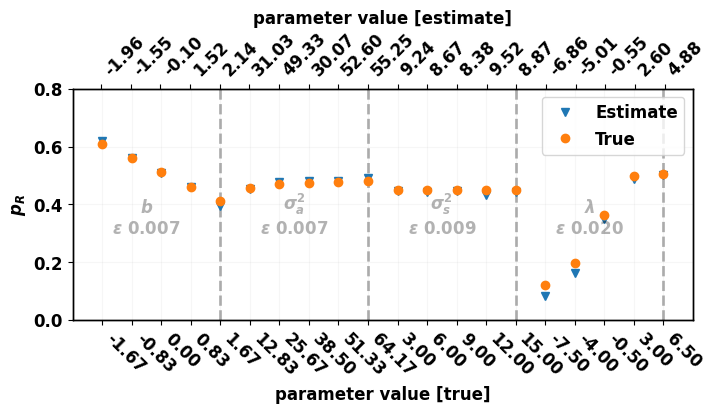

In [112]:
fig = plt.figure(figsize=(8,3))
plt.grid(alpha=0.1) 
plt.ylabel(f'$p_R$')
plt.xlabel('parameter value [true]')
plt.ylim([0,.8])
plt.xlim([-1, 20])
# plt vlines
plt.vlines(np.arange(4,20,5), 0, 1, colors='k', linestyles='--', lw=2, alpha=0.3)
# text align in center
plt.text(1.5, 0.3, f'$b$\n$\epsilon$ {error_parts[0]:.3f}', fontsize=12, ha='center', alpha=0.3)
plt.text(6.5, 0.3, f'$\sigma^2_a$\n$\epsilon$ {error_parts[1]:.3f}', fontsize=12, ha='center', alpha=0.3)
plt.text(11.5, 0.3, f'$\sigma^2_s$\n$\epsilon$ {error_parts[2]:.3f}', fontsize=12, ha='center', alpha=0.3)
plt.text(16.5, 0.3, f'$\lambda$\n$\epsilon$ {error_parts[3]:.3f}', fontsize=12, ha='center', alpha=0.3)

plt.plot(probR_estimate, 'v', label='Estimate', lw=2)
plt.plot(probR_true, 'o', label='True', lw=2)

# tick of x axis set as 0->20
xticks_label_array=np.array([all_thetas_dr[i, :, i].numpy() for i in range(4)]).reshape(-1)
# show 2 digits xtick label
xticks_label = [f'{x:4.2f}' for x in xticks_label_array]
plt.xticks(np.arange(20), xticks_label, rotation=-45, ha='left')

plt.legend()

# twinx
ax2 = plt.twiny()
# ax2.set_xlim(ax.get_xlim())
ax2.plot(np.arange(20), np.zeros(20), alpha=0)
xticks_label_array=np.array([theta_estimate[i, :, i] for i in range(4)]).reshape(-1)
xticks_label = [f'{x:4.2f}' for x in xticks_label_array]
ax2.set_xticks(np.arange(20), xticks_label, rotation=45, ha='left')
ax2.set_xlabel('parameter value [estimate]')

save_fig = fig_dir / 'npe-f' / f'{log_exp_id}-test-acc.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

In [94]:
def improvement_percentage(val_0, val_1):
    return np.abs((val_0 - val_1)) / val_1 * 100

print(prior_labels[0], improvement_percentage(0.007, 0.034))
print(prior_labels[1], improvement_percentage(0.007, 0.027))
print(prior_labels[2], improvement_percentage(0.009, 0.033))
print(prior_labels[3], improvement_percentage(0.020, 0.037))

$b$ 79.41176470588236
$\sigma^2_a$ 74.07407407407408
$\sigma^2_s$ 72.72727272727273
$\lambda$ 45.945945945945944


## [Qualitative] t-SNE

Compute feature_true from validation dataset

In [22]:
prior_limits, seqC, D, M, S, theta, probR = load_data(DATA_PATH, solver)
print(f"==>> seqC.shape: {seqC.shape}")
print(f"==>> theta.shape: {theta.shape}")

# compute features_true
num_C = 100
device = "cuda"
chR = probR_to_chR(probR, num_C, device)
print(f"==>> chR.shape: {chR.shape}")


print("".center(50, "-"))
print("==>> compute features_true")
features_true = extract_trained_features_from_seqC_chRs(seqC, chR, config)
print(f"==>> features_true.shape: {features_true.shape}")

==>> probR.shape: torch.Size([7, 3, 700, 1])
==>> seqC.shape: torch.Size([7, 3, 700, 15])
==>> theta.shape: torch.Size([1, 4])
==>> chR.shape: torch.Size([7, 3, 700, 100])
--------------------------------------------------
==>> compute features_true


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:09<00:00, 10.97it/s]

==>> features_true.shape: torch.Size([100, 456])


estimate the parameter from the feature

In [80]:
num_estimation = 3
feature_estimated_collection = []
theta_estimated_collection = []
for i in range(num_estimation):
    # find estimated theta using "kde"
    feature = features_true[i].reshape(1, -1, 1)
    print(f"==>> feature.shape: {feature.shape}")
    samples = sampling_from_posterior(device, posterior, feature)
    theta_estimated = estimate_theta_from_post_samples(prior_limits, torch.from_numpy(samples))

    theta_estimated = convert_samples_range(theta_estimated, normed_limits, designed_limits)
    theta_estimated = np.array(theta_estimated).reshape(1, -1)

    print(f"==>> theta: {theta}")
    print(f"==>> theta_estimated: {np.round(theta_estimated, 2)}")
    theta_estimated_collection.append(np.round(theta_estimated, 2))

    # compute the probR based on the estimated theta
    _, probR_estimated = DM_sim_for_seqCs_parallel_with_smaller_output(
        seqCs=seqC,
        prior=theta_estimated,
        num_prior_sample=1,
        privided_prior=True,
        model_name="B-G-L0S-O-N-",
    )
    probR_estimated = torch.from_numpy(probR_estimated.reshape(D, M, S, 1))
    chRs_estimated = probR_to_chR(probR_estimated, num_C, device)

    # # compute the feature from seqC and chR_estimated
    print("==>> computing features")
    features_estimated = extract_trained_features_from_seqC_chRs(seqC, chRs_estimated, config)
    print(f"==>> features_estimated.shape: {features_estimated.shape}")
    feature_estimated_collection.append(features_estimated)

==>> feature.shape: torch.Size([1, 456, 1])


100%|██████████| 4/4 [00:02<00:00,  1.46it/s]
/tmp/ipykernel_1794949/152148694.py:19: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  _, probR_estimated = DM_sim_for_seqCs_parallel_with_smaller_output(
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


==>> theta: tensor([[ 1.1093, 29.6747, 13.1014, -8.8007]])
==>> theta_estimated: [[ 1.46 24.4   8.63 -5.32]]

--- simulating pR with... ---
prior sample size: 1
model_name: B-G-L0S-O-N-
total number of simulations 14700 with 16 workers ...



[Parallel(n_jobs=16)]: Done 800 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 2800 tasks      | elapsed:    7.8s
[Parallel(n_jobs=16)]: Done 5600 tasks      | elapsed:   15.8s
[Parallel(n_jobs=16)]: Done 9200 tasks      | elapsed:   26.5s
[Parallel(n_jobs=16)]: Done 13600 tasks      | elapsed:   38.9s
[Parallel(n_jobs=16)]: Done 14700 out of 14700 | elapsed:   42.4s finished


time elapsed for simulation: 0.71 minutes
stacking the results
done stacking the results

seqC.shape: torch.Size([7, 3, 700, 15]), params.shape: (1, 4), probR.shape: (7, 3, 700, 1, 1)
==>> computing features


100%|██████████| 100/100 [00:09<00:00, 10.89it/s]


==>> features_estimated.shape: torch.Size([100, 456])
==>> feature.shape: torch.Size([1, 456, 1])


100%|██████████| 4/4 [00:02<00:00,  1.47it/s]
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


==>> theta: tensor([[ 1.1093, 29.6747, 13.1014, -8.8007]])
==>> theta_estimated: [[ 1.52 35.06  8.95 -5.83]]

--- simulating pR with... ---
prior sample size: 1
model_name: B-G-L0S-O-N-
total number of simulations 14700 with 16 workers ...



[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 1512 tasks      | elapsed:    4.1s
[Parallel(n_jobs=16)]: Done 2912 tasks      | elapsed:    7.7s
[Parallel(n_jobs=16)]: Done 4712 tasks      | elapsed:   12.1s
[Parallel(n_jobs=16)]: Done 6912 tasks      | elapsed:   17.7s
[Parallel(n_jobs=16)]: Done 9512 tasks      | elapsed:   24.1s
[Parallel(n_jobs=16)]: Done 12512 tasks      | elapsed:   31.6s
[Parallel(n_jobs=16)]: Done 14700 out of 14700 | elapsed:   37.0s finished


time elapsed for simulation: 0.62 minutes
stacking the results
done stacking the results

seqC.shape: torch.Size([7, 3, 700, 15]), params.shape: (1, 4), probR.shape: (7, 3, 700, 1, 1)
==>> computing features


100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


==>> features_estimated.shape: torch.Size([100, 456])
==>> feature.shape: torch.Size([1, 456, 1])


100%|██████████| 4/4 [00:02<00:00,  1.44it/s]
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


==>> theta: tensor([[ 1.1093, 29.6747, 13.1014, -8.8007]])
==>> theta_estimated: [[ 1.69 46.03  8.14 -5.21]]

--- simulating pR with... ---
prior sample size: 1
model_name: B-G-L0S-O-N-
total number of simulations 14700 with 16 workers ...



[Parallel(n_jobs=16)]: Done 800 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 2800 tasks      | elapsed:    7.3s
[Parallel(n_jobs=16)]: Done 5600 tasks      | elapsed:   14.4s
[Parallel(n_jobs=16)]: Done 9200 tasks      | elapsed:   23.3s
[Parallel(n_jobs=16)]: Done 13600 tasks      | elapsed:   34.7s
[Parallel(n_jobs=16)]: Done 14700 out of 14700 | elapsed:   37.6s finished


time elapsed for simulation: 0.63 minutes
stacking the results
done stacking the results

seqC.shape: torch.Size([7, 3, 700, 15]), params.shape: (1, 4), probR.shape: (7, 3, 700, 1, 1)
==>> computing features


100%|██████████| 100/100 [00:09<00:00, 10.90it/s]

==>> features_estimated.shape: torch.Size([100, 456])


In [83]:
len(feature_estimated_collection), feature_estimated_collection[0].shape

(3, torch.Size([100, 456]))

In [88]:
all_estimated_features = torch.cat(feature_estimated_collection, dim=0)
all_features = torch.cat([features_true, all_estimated_features], dim=0)
print(f"==>> all_features.shape: {all_features.shape}")

==>> all_features.shape: torch.Size([400, 456])


In [89]:
tsne = TSNE(n_components=2, random_state=0, perplexity=5)
features_embedded = tsne.fit_transform(all_features.squeeze().numpy())

参数分布

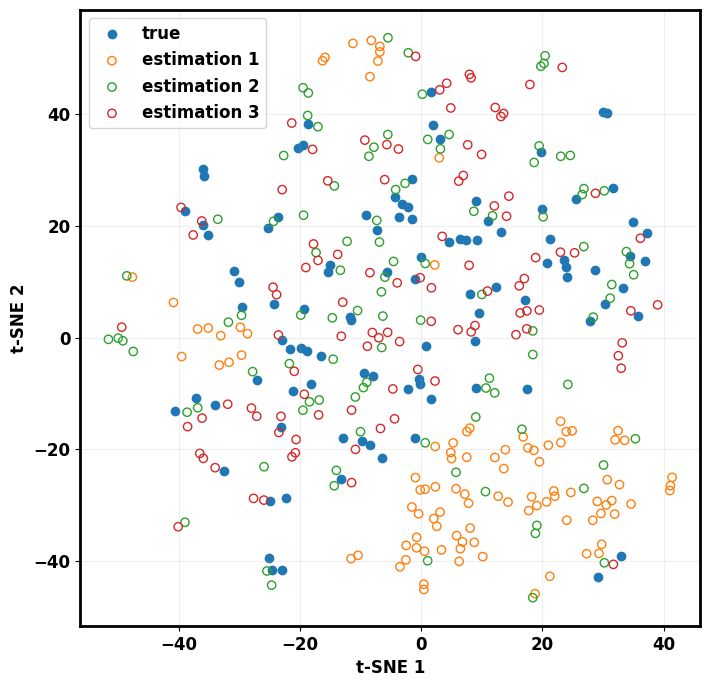

In [137]:
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(1+num_estimation):
    if i == 0:
        label='true'
    else:
        label=f'estimation {i}'
    ax.scatter(
        features_embedded[num_C*i:num_C*(i+1), 0],
        features_embedded[num_C*i:num_C*(i+1), 1],
        color=colors[i],
        label=label,
        # remove the filling of the markers
        facecolors='none' if i != 0 else colors[i],
    )
ax.legend()
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.grid()

save_fig = fig_dir / 'npe-f' / f'{log_exp_id}-t-SNE.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

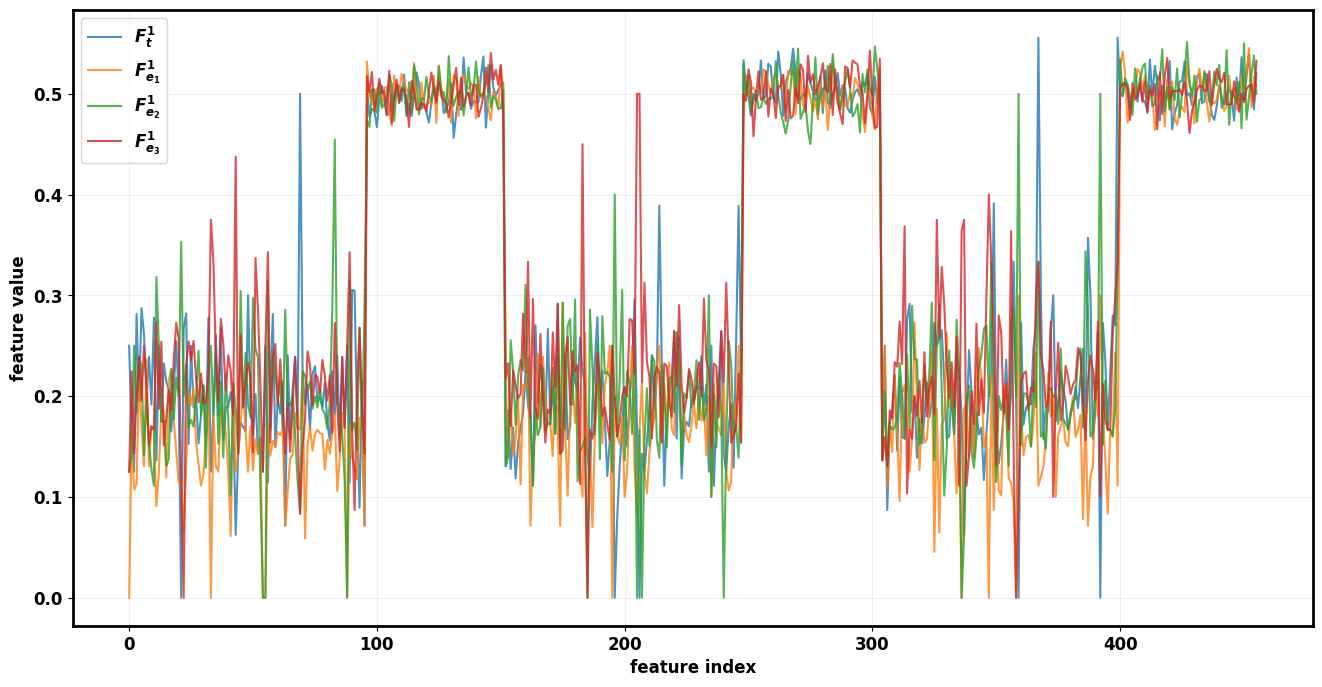

In [151]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(features_true[0,:], alpha=0.8, label='$F_t^1$')
plt.plot(all_estimated_features[0,:], alpha=0.8, label='$F_{e_1}^1$')
plt.plot(all_estimated_features[100,:], alpha=0.8, label='$F_{e_2}^1$')
plt.plot(all_estimated_features[200,:], alpha=0.8, label='$F_{e_3}^1$')
plt.grid()
plt.legend()
plt.xlabel('feature index')
plt.ylabel('feature value')

save_fig = fig_dir / 'npe-f' / f'{log_exp_id}-t-SNE-features.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

In [143]:
distances = []
for i in range(1+num_estimation):
    distances.append(distance.pdist(features_embedded[i*num_C:(i+1)*num_C], "euclidean"))

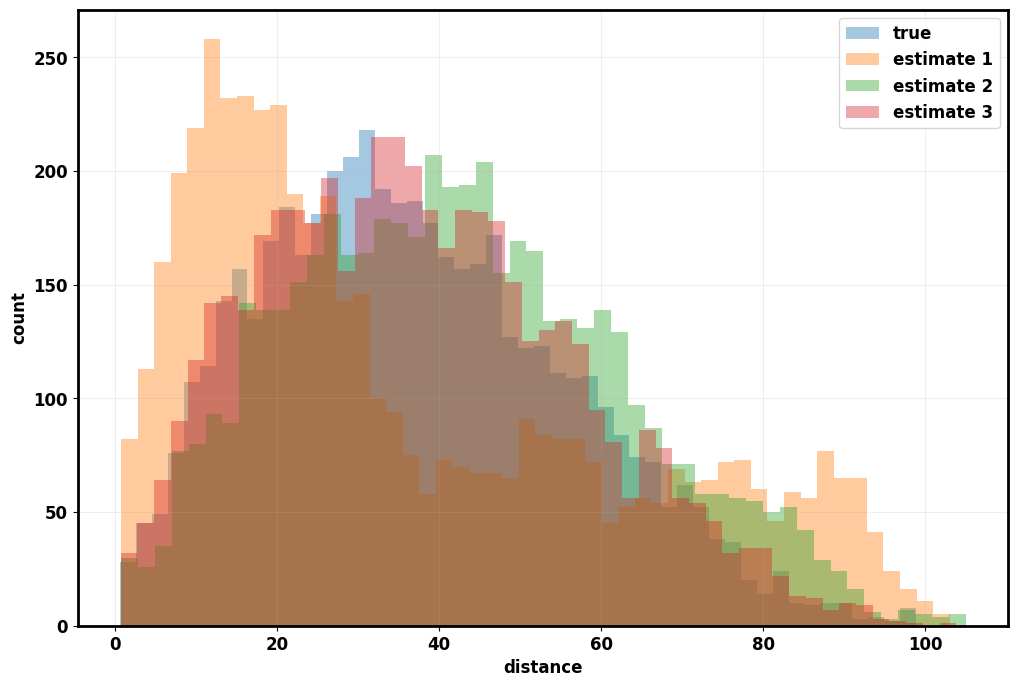

In [150]:
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(len(distances)):
    label = "true" if i == 0 else f"estimate {i}"
    plt.hist(distances[i], alpha=0.4, label=label, bins=50)
plt.legend()
plt.grid()
plt.xlabel("distance")
plt.ylabel("count")

save_fig = fig_dir / 'npe-f' / f'{log_exp_id}-t-SNE-hist.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## [Quantitively] Evaluate the performance of the trained model on the validation dataset

### ci [20, 50, 95]

In [53]:
from utils.inference import samples_on_dset
samples_collection, thetas = samples_on_dset(posterior, valid_dataset)

  0%|          | 6/25000 [00:00<07:13, 57.62it/s]

100%|██████████| 25000/25000 [05:49<00:00, 71.54it/s]


In [67]:
save_npy = fig_dir / "npe-f" / f"{log_exp_id}-samples_collection.npy"
np.save(save_npy, samples_collection)
save_npy = fig_dir / "npe-f" / f"{log_exp_id}-thetas.npy"
np.save(save_npy, thetas)

In [55]:
credible_intervals = [20, 50, 95]
ci = perfs_on_dset(
    samples_collection,
    thetas,
    credible_intervals,
    num_params,
    prior_limits,
    mode="ci",
)


100%|██████████| 25000/25000 [00:19<00:00, 1288.17it/s]


In [64]:
save_npy = fig_dir / "npe-f" / f"{log_exp_id}-ci.npy"
np.save(save_npy, ci)

In [126]:
print(f"ci_valid {log_exp_id}:\n", ci)

ci_valid npe-f-F1345-mdn:
 [[0.19744 0.12424 0.14752 0.17808]
 [0.46248 0.36184 0.37312 0.45536]
 [0.92264 0.89068 0.88004 0.91124]]


In [75]:
print(f"ci_valid {log_exp_id}:\n", ci)

ci_valid npe-f-F1345-maf3:
 [[0.1684  0.14832 0.14476 0.1924 ]
 [0.43692 0.37568 0.37404 0.48308]
 [0.90676 0.89096 0.87972 0.93164]]


### mean prediction error

In [148]:
mse_mean, est_mean_s = perfs_on_dset(
    samples_collection,
    thetas,
    credible_intervals,
    num_params,
    prior_limits,
    mode="mean",
)

  6%|▌         | 1461/25000 [00:00<00:01, 14604.27it/s]

100%|██████████| 25000/25000 [00:01<00:00, 14834.65it/s]


In [149]:
save_npy = fig_dir / "npe-f" / f"{log_exp_id}-mse_mean.npy"
np.save(save_npy, mse_mean)
save_npy = fig_dir / "npe-f" / f"{log_exp_id}-est_mean.npy"
np.save(save_npy, est_mean_s)

In [150]:
print(f"{log_exp_id} valid \nmean mse\n", mse_mean)

npe-f-F1345-maf3 valid 
mean mse
 [0.00956242 0.05420174 0.0812087  0.016593  ]


### median prediction error

In [141]:
mse_median, est_median_s = perfs_on_dset(
    samples_collection,
    thetas,
    credible_intervals,
    num_params,
    prior_limits,
    mode="median",
)

  2%|▏         | 515/25000 [00:00<00:04, 5145.22it/s]

100%|██████████| 25000/25000 [00:04<00:00, 5386.04it/s]


In [142]:
save_npy = fig_dir / "npe-f" / f"{log_exp_id}-mse_median.npy"
np.save(save_npy, mse_median)
save_npy = fig_dir / "npe-f" / f"{log_exp_id}-est_median.npy"
np.save(save_npy, est_median_s)

In [146]:
print(f"{log_exp_id} valid \nmedian mse\n", mse_median)

npe-f-F1345-maf3 valid 
median mse
 [0.00949021 0.0543478  0.08124805 0.01702186]


### mode prediction error

In [ ]:
mse_mode, est_mode_s = perfs_on_dset(
    samples_collection,
    thetas,
    credible_intervals,
    num_params,
    prior_limits,
    mode="mode",
)

save_npy = fig_dir / "npe-f" / f"{log_exp_id}-mse_mode.npy"
np.save(save_npy, mse_mode)
print('saved to', save_npy)
save_npy = fig_dir / "npe-f" / f"{log_exp_id}-est_mode.npy"
np.save(save_npy, est_mode_s)
print('saved to', save_npy)

  0%|          | 0/25000 [00:00<?, ?it/s]

100%|██████████| 25000/25000 [1:57:57<00:00,  3.53it/s]  

saved to /home/wehe/tmp/NSC/codes/notebook/figures/npe-f/npe-f-F1345-maf3-mse_mode.npy
saved to /home/wehe/tmp/NSC/codes/notebook/figures/npe-f/npe-f-F1345-maf3-est_mode.npy


In [154]:
mse_mode = np.mean(np.square(np.array(est_mode_s) - np.array(thetas)), axis=0)

In [155]:
print(f"{log_exp_id} valid \nmode mse\n", mse_mode)

npe-f-F1345-maf3 valid 
mode mse
 [0.00959299 0.05838669 0.08327798 0.02071455]


### c2st

In [169]:
save_npy = fig_dir / "npe-f" / f"{log_exp_id}-est_mode.npy"
est_mode = np.load(save_npy)

save_npy = fig_dir / "npe-f" / f"{log_exp_id}-est_mean.npy"
est_mean = np.load(save_npy)

save_npy = fig_dir / "npe-f" / f"{log_exp_id}-est_median.npy"
est_median = np.load(save_npy)

save_npy = fig_dir / "npe-f" / f"{log_exp_id}-samples_collection.npy"
samples_collection = np.load(save_npy)

save_npy = fig_dir / "npe-f" / f"{log_exp_id}-thetas.npy"
thetas = np.load(save_npy)


In [170]:
from sbi.utils.metrics import c2st
from utils.inference import my_c2st

In [172]:
num_C_valid_dataset = 25
# vstack thetas
thetas_true = np.stack(thetas)
est_mode = torch.from_numpy(np.stack(est_mode_s))
est_mean = torch.from_numpy(np.stack(est_mean_s))
est_median = torch.from_numpy(np.stack(est_median_s))

# thetas_true = thetas_true[::num_C_valid_dataset]
# est_mode = est_mode[::num_C_valid_dataset]
# est_mean = est_mean[::num_C_valid_dataset]
# est_median = est_median[::num_C_valid_dataset]

In [179]:
def check_c2st(num_params, chosen_theta):
    c2st_mode = my_c2st(
    thetas_true[:, chosen_theta],
    est_mode[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
    print(f"==>> chosen_theta: {chosen_theta}")
    print(f"==>> my_c2st_mode: {c2st_mode}")
    c2st_median = my_c2st(
    thetas_true[:, chosen_theta],
    est_median[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
    print(f"==>> my_c2st_median: {c2st_median}")

    c2st_mean = my_c2st(
    thetas_true[:, chosen_theta],
    est_mean[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
    print(f"==>> my_c2st_mean: {c2st_mean}")

In [180]:
num_params = 4
chosen_theta = [0, 1, 2, 3]
check_c2st(num_params, chosen_theta)

num_params = 3
chosen_theta = [0, 1, 3]
check_c2st(num_params, chosen_theta)

num_params = 2
chosen_theta = [0, 3]
check_c2st(num_params, chosen_theta)

num_params = 1
chosen_theta = [0]
check_c2st(num_params, chosen_theta)

num_params = 1
chosen_theta = [1]
check_c2st(num_params, chosen_theta)

num_params = 1
chosen_theta = [2]
check_c2st(num_params, chosen_theta)

num_params = 1
chosen_theta = [3]
check_c2st(num_params, chosen_theta)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


==>> chosen_theta: [0, 1, 2, 3]
==>> my_c2st_mode: 0.9003999829292297


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


==>> my_c2st_median: 0.9836999773979187


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


==>> my_c2st_mean: 0.984000027179718


100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


==>> chosen_theta: [0, 1, 3]
==>> my_c2st_mode: 0.7239999771118164


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


==>> my_c2st_median: 0.7768999934196472


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


==>> my_c2st_mean: 0.796999990940094


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


==>> chosen_theta: [0, 3]
==>> my_c2st_mode: 0.5586000084877014


100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


==>> my_c2st_median: 0.6344000101089478


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


==>> my_c2st_mean: 0.6223999857902527


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


==>> chosen_theta: [0]
==>> my_c2st_mode: 0.5411999821662903


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


==>> my_c2st_median: 0.5853999853134155


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


==>> my_c2st_mean: 0.6115000247955322


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


==>> chosen_theta: [1]
==>> my_c2st_mode: 0.4821000099182129


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


==>> my_c2st_median: 0.7152000069618225


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


==>> my_c2st_mean: 0.7321000099182129


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


==>> chosen_theta: [2]
==>> my_c2st_mode: 0.8802000284194946


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


==>> my_c2st_median: 0.9714000225067139


100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


==>> my_c2st_mean: 0.9760000109672546


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


==>> chosen_theta: [3]
==>> my_c2st_mode: 0.6074000000953674


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


==>> my_c2st_median: 0.6313999891281128


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]

==>> my_c2st_mean: 0.6564000248908997
